# APPM 4720 Applied Deep Learning, Spring 2022
## Progress Report 07 - Recommender System
### Variational Autoencoders for Collaborative Filtering
### By Sabrina Liu

Examined and implemented the **Multinomial Variational Autoencoder** algorithm as described in 2018 paper by Netflix research *Variational Autoencoders for Collaborative Filtering* in Keras. Trained the model on `movielens-1m` dataset and achived some preliminary results.  

#### References:
* Paper: Liang, et.al., *Variational Autoencoders for Collaborative Filtering*, https://arxiv.org/pdf/1802.05814
* Dataset: https://grouplens.org/datasets/movielens/
* Official Repo: https://github.com/dawenl/vae_cf/blob/master/VAE_ML20M_WWW2018.ipynb
* Tutorial: https://github.com/microsoft/recommenders/tree/main/recommenders/models/vae

This report re-implemented the algorithm demonstrated in the official repo and the Microsoft tutorial using Keras API. 

---
## Set Up Environment

#### Mount Google Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=False)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
%cd '/content/drive/MyDrive/ADL/RecommenderVAE'
!dir

/content/drive/MyDrive/ADL/RecommenderVAE
data		   df_score_mask.csv  df_valid_mask.csv  models
df_score_keep.csv  df_valid_keep.csv  images


In [3]:
import tensorflow as tf
tf.__version__

'2.8.0'

In [4]:
gpus = tf.config.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [5]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
    print('Not connected to a GPU')
else:
    print(gpu_info)

Wed Apr 27 01:37:24 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P0    25W / 300W |      2MiB / 16160MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

---
## Architecture Review

The goal of **collaborative filtering** is to predict what items a user will prefer by learning from the patterns across all users over all items. Often, the architectures adopted for collaborative filtering are inherently linear. In this paper, **variational autoencoders (VAE)**, a type of generative model, is introduced to enable non-linearity and to generalize the linear latent-factor models. 

#### Variational Autoencoder

Different from standard autoencoders which learns a low-dimension latent feature representation of the input through reconstruction, variational autoencoders learns the the distribution of the latent feature, and samples from the distribution to be used for reconstruction. In this model, the distribution is parameterized as mean and log-variance. At the sampling step,  the **reparametrization trick** is used to bypass gradient calculation by applying the mean and standard deviation to random Gaussian noise $ϵ$ in order to generate the feature vector $z_u$ representing the preferences of user $u$ based on history data $x_u$:

$$ \epsilon \sim \mathcal{N}(0, \textbf{I}_K) $$
$$ z_u = \mu_\phi(x_u) + ϵ \odot \sigma_\phi(x_u) $$




#### Multinomial Likelihood
The data availability based on user history is sparse, i.e. in the movie review dataset, each user only reviews a few movies, and each movie is only reviewed by a few users. Therefore, a robust probabilistic model that shares statistical strength among both users and items is required to make good recommendations. This is the motivation of utilizing multinomial distribution. To achieve this, the latent representation $z_u$ is transformed via a non-linear function $f_\theta(\cdot)$ to produce a probability $\pi(z_u)$ over $I$ items:

$$ z_u \sim \mathcal{N}(0, \textbf{I}_K)  $$
$$ \pi(z_u) ∝ \exp\{f_\theta(z_u)\} $$

The non-linear function $f_\theta$ is a multilayer perceptron (MLP) with parameters $\theta$. The output of this transformation is normalized via a softmax function to produce a probility vector $\pi(z_u)$. Given the total number of watch history $N_u = \sum_i x_{ui}$ from user $u$, where $u$ indexes the user and $i$ indexes the item, the observed bag-of-words vector $x_u$ is assumed to be sampled from a multinomial distribution $\pi(z_u)$:
$$ x_u \sim \text{Mult}(N_u, \pi(z_u)) $$


#### Variation Inference

The variational autoencoder learns to approximate the intractible posterior distribution $p(z_u|x_u)$ with a simpler variational distribution $q(z_u)$:

$$ q(z_u) = \mathcal{N}(\mu_u, \text{diag}\{\sigma_u^2\}) $$

The objective of variational inference is to optimize the free variational parameters (for each user) $\{\mu_u, \sigma_u^2\}$ so that the Kullback-Leiber divergence $\text{KL}(q(z_u)||p(z_u|x_u))$ is minimized. 

#### Objective Function

The overall objective function is obtained by averaging the objective function over all the users (each line of training data represents a different user) which aims to maximize the log likelihood for each user. To learn the latent variables, a lower bound is set to the log marginal likelihood, which is known as the **evidence lower bound (ELBO)** method: 

$$ \log p(x_u;\theta) \ge \mathbb{E}_{q_\phi(z_u|x_u)}[\log p_\theta(x_u|z_u)] - \text{KL}(p(z_u)||q_\phi(z_u|x_u)) \equiv \mathcal{L}(x_u; \theta, \phi) $$ 

The first term can be viewed as (negative) reconstruction error, and the second term can be viewed as regularization. The authors argued that this objective is over-regularized, therefore applying a hyperparameter $\beta$ between 0 and 1 to weight the KL divergence:

$$ \mathcal{L}(x_u; \theta, \phi) \equiv \mathbb{E}_{q_\phi(z_u|x_u)}[\log p_\theta(x_u|z_u)] - \beta \cdot \text{KL}(p(z_u)||q_\phi(z_u|x_u)) $$ 

In the original research, the authors also used a technique called **annealing** to optimize $\beta$, which increases the value of $\beta$ gradually from 0 to 1 slowly over a large number of gradient updates and record the best $\beta$ when its performance reaches the peak. Due to its level of complexity, annealing was not implemented in this project report. $\beta$ is set to 0.2 for this exercise. 

---
## The MovieLens Dataset

The movielens dataset contains several different sizes of datasets, e.g. 1m, 10m, 25m, etc. For simplicity this project used the 1m dataset. The `movies.dat` file contains movie Id, title and genres and the `ratings.dat` file contains movie review score information by users in the format of stacked line records. Each record shows the user Id, the movie Id, and the rating score (0-5). The `movielens-1m` dataset contains roughly 1 million ratings, including 3000+ movies reviewed by 6000+ users, as shown in below analysis. 

https://grouplens.org/datasets/movielens/

In [6]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [7]:
filepath = 'data/movielens-1m'
os.listdir(filepath)

['movies.dat', 'ratings.dat', 'users.dat', 'README']

#### Check out the Movies

In [8]:
moviefile = os.path.join(filepath, 'movies.dat')
!head -3 $moviefile

1::Toy Story (1995)::Animation|Children's|Comedy
2::Jumanji (1995)::Adventure|Children's|Fantasy
3::Grumpier Old Men (1995)::Comedy|Romance


In [9]:
%%time
df_mov = pd.read_table(
    moviefile,
    sep='::', engine='python',
    names=['movieId', 'title', 'genres'],
    encoding='ISO-8859-1',
    dtype={'movieId':'int32'},
)
display(df_mov)

,movieId,title,genres
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy
...,...,...,...
3878,3948,Meet the Parents (2000),Comedy
3879,3949,Requiem for a Dream (2000),Drama
3880,3950,Tigerland (2000),Drama
3881,3951,Two Family House (2000),Drama


CPU times: user 22.5 ms, sys: 3.17 ms, total: 25.7 ms
Wall time: 26 ms


In [10]:
df_mov.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3883 entries, 0 to 3882
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  3883 non-null   int32 
 1   title    3883 non-null   object
 2   genres   3883 non-null   object
dtypes: int32(1), object(2)
memory usage: 76.0+ KB


#### Build Movie Dictionary for Lookup

Now build a dictionary for later lookup using movie IDs. Note that the movie ID starts at index 1. 

In [11]:
dict_movies = {k:v for k,v in zip(df_mov.movieId, df_mov.title)}
dict_movies[1]

'Toy Story (1995)'

#### Trending by Year and Genre

The dataset contains near 20 different genres. When checking the number of movies by their release year and genres, it can be seen that most of the movies watched (reviewed) were produced after 1980 with a big burst between 1995 and 2000, across all genres. 

In [12]:
df_mov['year'] = df_mov['title'].apply(lambda x: x[-5:-1] if x[-5:-1] >= '1800' and x[-5:-1] <= '2022' else 'NA')

In [13]:
genres = df_mov.genres.unique()
genres = [rec.split('|') for rec in genres]
genres = sorted(list(set(gen for rec in genres for gen in rec)))
', '.join(genres)

"Action, Adventure, Animation, Children's, Comedy, Crime, Documentary, Drama, Fantasy, Film-Noir, Horror, Musical, Mystery, Romance, Sci-Fi, Thriller, War, Western"

In [14]:
for gen in genres:
    df_mov[gen] = df_mov.genres.apply(lambda x: gen in x)

df_mov[['movieId', 'title', 'year' ,'Action', 'Adventure', 'Animation', 'Comedy']]

,movieId,title,year,Action,Adventure,Animation,Comedy
0,1,Toy Story (1995),1995,False,False,True,True
1,2,Jumanji (1995),1995,False,True,False,False
2,3,Grumpier Old Men (1995),1995,False,False,False,True
3,4,Waiting to Exhale (1995),1995,False,False,False,True
4,5,Father of the Bride Part II (1995),1995,False,False,False,True
...,...,...,...,...,...,...,...
3878,3948,Meet the Parents (2000),2000,False,False,False,True
3879,3949,Requiem for a Dream (2000),2000,False,False,False,False
3880,3950,Tigerland (2000),2000,False,False,False,False
3881,3951,Two Family House (2000),2000,False,False,False,False


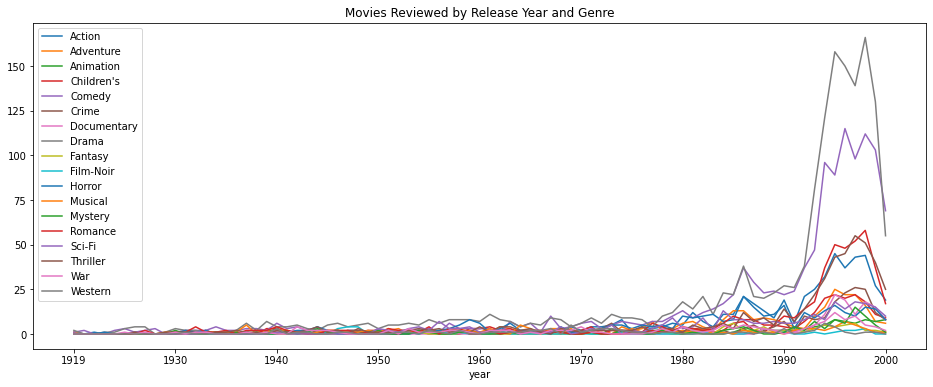

In [15]:
df_agg = df_mov.groupby('year').sum().drop(columns='movieId')
_ = df_agg.plot(figsize=(16, 6), title='Movies Reviewed by Release Year and Genre')

#### Check out the Ratings

In [16]:
scorefile = os.path.join(filepath, 'ratings.dat')
!head -3 $scorefile

1::1193::5::978300760
1::661::3::978302109
1::914::3::978301968


In [17]:
%%time
df_raw = pd.read_csv(
    scorefile,
    sep='::', engine='python',
    names=['userId', 'movieId', 'rating', 'timestamp'],
    usecols=['userId', 'movieId', 'rating'],
    dtype={'userId':'int32','movieId':'int32','rating':'float32'},
    encoding='ISO-8859-1',
)
display(df_raw)

,userId,movieId,rating
0,1,1193,5.0
1,1,661,3.0
2,1,914,3.0
3,1,3408,4.0
4,1,2355,5.0
...,...,...,...
1000204,6040,1091,1.0
1000205,6040,1094,5.0
1000206,6040,562,5.0
1000207,6040,1096,4.0


CPU times: user 4.17 s, sys: 238 ms, total: 4.41 s
Wall time: 4.34 s


In [18]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000209 entries, 0 to 1000208
Data columns (total 3 columns):
 #   Column   Non-Null Count    Dtype  
---  ------   --------------    -----  
 0   userId   1000209 non-null  int32  
 1   movieId  1000209 non-null  int32  
 2   rating   1000209 non-null  float32
dtypes: float32(1), int32(2)
memory usage: 11.4 MB


In [19]:
print("Unique Users:", df_raw.userId.nunique())
print("Unique Movies:", df_raw.movieId.nunique())

Unique Users: 6040
Unique Movies: 3706


#### Sparsity of Data

The above line records can be pivoted into a matrix with user ID as row indices and movie Id as column indices. This matrix is very sparse with part of it shown below. 

In [20]:
%%time
df_tab = df_raw.pivot(index='userId', columns='movieId', values='rating')
display(df_tab.head().fillna(''))

movieId,1,2,3,4,5,6,7,8,9,10,...,3943,3944,3945,3946,3947,3948,3949,3950,3951,3952
userId,,,,,,,,,,,,,,,,,,,,,
1,5.0,,,,,,,,,,...,,,,,,,,,,
2,,,,,,,,,,,...,,,,,,,,,,
3,,,,,,,,,,,...,,,,,,,,,,
4,,,,,,,,,,,...,,,,,,,,,,
5,,,,,,2.0,,,,,...,,,,,,,,,,


CPU times: user 1.2 s, sys: 112 ms, total: 1.31 s
Wall time: 1.21 s


In [21]:
reviews = df_tab.count().sum()  # equal to len(df_raw)
pairs = df_tab.size

print("Total Reviews:".ljust(16), reviews)
print("Total Pairs:".ljust(16), pairs)
print("Event Density:".ljust(16), round(reviews / pairs, 4))

Total Reviews:   1000209
Total Pairs:     22384240
Event Density:   0.0447


#### Movies Reviewed per User

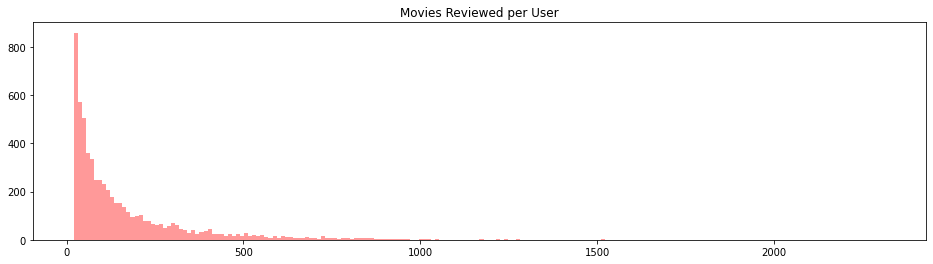

In [22]:
plt.figure(figsize=(16, 4))
_ = plt.hist(df_tab.count(axis=1), bins=200, color='r', alpha=.4)
_ = plt.title('Movies Reviewed per User')

#### Reviewing Users per Movie

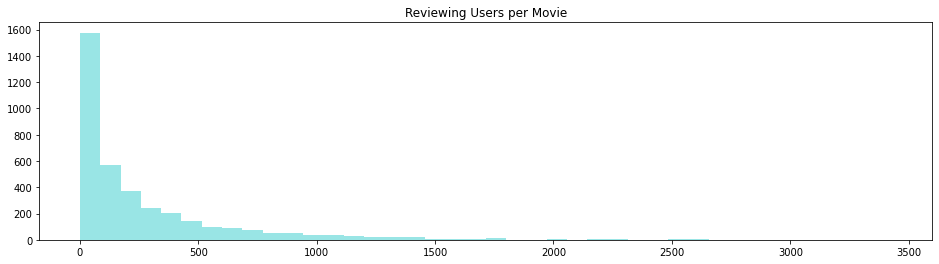

In [23]:
plt.figure(figsize=(16, 4))
_ = plt.hist(df_tab.count(), bins=40, color='c', alpha=.4)
_ = plt.title('Reviewing Users per Movie')

#### Movies with Most Reviews

Below lists top 5 movies with most reviews and their respective average review scores. Interestingly, being watched and reviewed a lot doesn't necessarily mean the movie must have a high score. 

In [24]:
top5_reviewed = df_tab.count().sort_values(ascending=False)[:5]
top5_reviewed = pd.DataFrame(top5_reviewed, columns=['n_reviews']).reset_index()
top5_reviewed['avg_score'] = top5_reviewed['movieId'].apply(lambda x: df_tab[x].mean())
top5_reviewed['title'] = top5_reviewed['movieId'].apply(lambda x: dict_movies[x])
top5_reviewed

,movieId,n_reviews,avg_score,title
0,2858,3428,4.317386,American Beauty (1999)
1,260,2991,4.453694,Star Wars: Episode IV - A New Hope (1977)
2,1196,2990,4.292976,Star Wars: Episode V - The Empire Strikes Back...
3,1210,2883,4.022893,Star Wars: Episode VI - Return of the Jedi (1983)
4,480,2672,3.763847,Jurassic Park (1993)


#### Movies with Highest Reviews

Below shows several movies with the highest average score (5.0) of all movies. However, these movies only have very few viewers. It's not common for a very popular movie to make everyone perfectly happy. 



In [25]:
top5_scores = df_tab.mean().sort_values(ascending=False)[:5]
top5_scores = pd.DataFrame(top5_scores, columns=['avg_score']).reset_index()
top5_scores['n_reviews'] = top5_scores['movieId'].apply(lambda x: df_tab[x].count())
top5_scores['title'] = top5_scores['movieId'].apply(lambda x: dict_movies[x])
top5_scores

,movieId,avg_score,n_reviews,title
0,989,5.0,1,Schlafes Bruder (Brother of Sleep) (1995)
1,3881,5.0,1,Bittersweet Motel (2000)
2,1830,5.0,1,Follow the Bitch (1998)
3,3382,5.0,1,Song of Freedom (1936)
4,787,5.0,3,"Gate of Heavenly Peace, The (1995)"


---
## Preprocessing

#### Filter by Frequency

We only need to keep movies with at least 5 reviews for information. The final unique count of users and movies are as below. This operation did not change the sparsity level very much. 

In [26]:
REVIEW_THRESH = 5
idx_movies = df_tab.count() >= REVIEW_THRESH

df_new = df_tab.loc[:, idx_movies]
df_new.shape

(6040, 3416)

In [27]:
N_USERS, N_MOVIES = df_new.shape

In [28]:
reviews = df_new.count().sum()
pairs = df_new.size
print("Filtered Reviews:".ljust(16), reviews)
print("Filterd Pairs:".ljust(16), pairs)
print("Filtered Density:".ljust(16), round(reviews / pairs, 4))

Filtered Reviews: 999611
Filterd Pairs:   20632640
Filtered Density: 0.0484


#### Split for Train-Validation-Test

In our data, each row represents the watch history of a user, and each column represents a movie. Here we slice out 4000 rows for training, 1000 rows for validation, and keep the rest for evaluation. 

In [29]:
df_new.shape

(6040, 3416)

In [30]:
df_train = df_new[:4000]
df_valid = df_new[4000:5000]
df_score = df_new[5000:]

df_train.shape, df_valid.shape, df_score.shape

((4000, 3416), (1000, 3416), (1040, 3416))

#### Reserve Prediction Part

For training, we use the complete user watch history for reconstruction. For metrics calculation on both validation and evaluation subsets, we mask out 20% of the watch history for each user and use the other movies as "already watched movies" as inputs to make top-k predictions. The top-k predictions can then be compared to the masked out movies to evaluate the recommendation quality. For this model, binary values are used to represent the "click history". 

In [31]:
def split_row(row, mask_ratio=.2):  # takes pd.Series
    idx = pd.notnull(row)               # convert to binary values
    hist = df_new.columns[idx]          # select watch history movie ids
    n = int(len(hist) * mask_ratio)     # sample size to mask per user
    samp = np.random.choice(hist, n, replace=False)
    keep = idx.copy()
    keep[samp] = False                  # movies to keep and use as information
    mask = idx.copy()
    mask[keep] = False                  # movies to mask and use for evaluation
    return keep, mask

row = df_new.iloc[0]
a, b = split_row(row)

hist = df_new.columns[pd.notna(row)]
keep = df_new.columns[a==True]
mask = df_new.columns[b==True]

print(hist)
print(keep)
print(mask)

assert set(hist) == set(keep.tolist() + mask.tolist())

Int64Index([   1,   48,  150,  260,  527,  531,  588,  594,  595,  608,  661,
             720,  745,  783,  914,  919,  938, 1022, 1028, 1029, 1035, 1097,
            1193, 1197, 1207, 1246, 1270, 1287, 1545, 1566, 1721, 1836, 1907,
            1961, 1962, 2018, 2028, 2294, 2321, 2340, 2355, 2398, 2687, 2692,
            2762, 2791, 2797, 2804, 2918, 3105, 3114, 3186, 3408],
           dtype='int64', name='movieId')
Int64Index([  48,  150,  260,  527,  588,  594,  595,  608,  661,  720,  745,
             783,  914,  919,  938, 1022, 1028, 1035, 1097, 1193, 1197, 1207,
            1246, 1287, 1545, 1721, 1907, 1961, 1962, 2018, 2028, 2294, 2321,
            2340, 2398, 2762, 2791, 2797, 2804, 2918, 3105, 3114, 3408],
           dtype='int64', name='movieId')
Int64Index([1, 531, 1029, 1270, 1566, 1836, 2355, 2687, 2692, 3186], dtype='int64', name='movieId')


In [32]:
from tqdm import trange

def reserve_split(df):
    df_keep = pd.DataFrame()
    df_mask = pd.DataFrame()
    for i in trange(len(df)):
        row = df.iloc[i]
        row_keep, row_mask = split_row(row)
        df_keep = pd.concat([df_keep, row_keep], axis=1)
        df_mask = pd.concat([df_mask, row_mask], axis=1)
    return df_keep.T, df_mask.T

if os.path.exists('df_valid_keep.csv'):
    print("reading dataframes from csv files ...")
    df_valid_keep = pd.read_csv('df_valid_keep.csv', index_col=0)
    df_valid_mask = pd.read_csv('df_valid_mask.csv', index_col=0)
    df_score_keep = pd.read_csv('df_score_keep.csv', index_col=0)
    df_score_mask = pd.read_csv('df_score_mask.csv', index_col=0)
else:
    df_valid_keep, df_valid_mask = reserve_split(df_valid)
    df_score_keep, df_score_mask = reserve_split(df_score)
    print("saving dataframes to csv files ...")
    df_valid_keep.to_csv('df_valid_keep.csv')
    df_valid_mask.to_csv('df_valid_mask.csv')
    df_score_keep.to_csv('df_score_keep.csv')
    df_score_mask.to_csv('df_score_mask.csv')

print(df_valid_keep.shape, df_valid_mask.shape, df_score_keep.shape, df_score_mask.shape)

reading dataframes from csv files ...
(1000, 3416) (1000, 3416) (1040, 3416) (1040, 3416)


In [33]:
df_valid_keep.head()

,1,2,3,4,5,6,7,8,9,10,...,3943,3944,3945,3946,3947,3948,3949,3950,3951,3952
4001,True,False,True,False,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4002,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4003,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4004,False,False,False,False,False,True,False,False,False,True,...,False,False,False,False,False,False,False,False,False,False
4005,True,False,False,False,False,True,False,False,False,False,...,False,False,False,False,False,True,False,False,False,False


#### Convert to Tensorflow Batched Dataset

As explained earlier, the train subset takes the entire watch history for selected users all together, whereas the validation and evaluation subsets takes paired data, repsectively used as history and ground truth. 

In [34]:
BATCH_SIZE = 64

In [35]:
def to_tensor(df):
    df_bin = df.astype('float32').to_numpy()
    return tf.data.Dataset.from_tensor_slices(df_bin)

x_train = to_tensor(pd.notna(df_train)).batch(BATCH_SIZE)

x_valid = tf.data.Dataset.zip((to_tensor(df_valid_keep), to_tensor(df_valid_mask))).batch(BATCH_SIZE)
x_score = tf.data.Dataset.zip((to_tensor(df_score_keep), to_tensor(df_score_mask))).batch(BATCH_SIZE)

for a, (b, c), (d, e) in zip(x_train.take(1), x_valid.take(1), x_score.take(1)):
    print(a.shape, b.shape, c.shape, d.shape, e.shape)

(64, 3416) (64, 3416) (64, 3416) (64, 3416) (64, 3416)


---
## Model Implementation

The encoder and decoder parts of the model are mostly simple MLPs, built as below. The `Lambda` layer allows us to define customized layer based on mathematical operations, such as the implementation of the variational encoder sampling process. 

In [36]:
HIDDEN_DIM = 200
LATENT_DIM = 100

In [37]:
from tensorflow.keras import backend as K

In [38]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Lambda
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense

In [39]:
def Encoder(input_dim=N_MOVIES,  hidden_dim=HIDDEN_DIM, latent_dim=LATENT_DIM,summary=False):
    """
    produce latent space distribution (mu and sigma) and latent vector (z)
    """

    x = Input(shape=input_dim, name='encoder_input')
    z = Lambda(lambda a: tf.math.l2_normalize(a, axis=1), name='encoder_normalize')(x)
    z = Dropout(rate=0.5, name='encoder_dropout')(z)
    z = Dense(units=hidden_dim, activation='tanh', name='encoder_perceptron')(z)

    # generate distributions
    m = Dense(units=latent_dim, name='mean')(z)  # mean
    v = Dense(units=latent_dim, name='logvar')(z)  # log variance

    # generate latent vector
    def _sample(args):
        mu, logvar = args
        # reparameterization
        epsilon = tf.random.normal(
            mean=0., stddev=1.,
            shape=(K.shape(mu)[0], latent_dim)
        )
        std = K.exp(logvar / 2)
        return epsilon * std + mu

    z = Lambda(_sample, name='sample')([m, v])

    model = Model(inputs=x, outputs=[m, v, z], name='Encoder')
    
    if summary:
        display(model.summary())
    
    return model

_ = Encoder(summary=True)

Model: "Encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_input (InputLayer)     [(None, 3416)]       0           []                               
                                                                                                  
 encoder_normalize (Lambda)     (None, 3416)         0           ['encoder_input[0][0]']          
                                                                                                  
 encoder_dropout (Dropout)      (None, 3416)         0           ['encoder_normalize[0][0]']      
                                                                                                  
 encoder_perceptron (Dense)     (None, 200)          683400      ['encoder_dropout[0][0]']        
                                                                                            

None

In [40]:
def Decoder(output_dim=N_MOVIES, hidden_dim=HIDDEN_DIM, latent_dim=LATENT_DIM, summary=False):
    """
    reconstruct input vector from latent vector (z)
    """

    x = Input(shape=latent_dim, name='decoder_input')
    z = Dense(units=hidden_dim, activation='tanh', name='decoder_perceptron')(x)
    z = Dense(output_dim, name='reconstruct')(z)
    z = Dropout(rate=0.5, name='decoder_dropout')(z)

    model = Model(inputs=x, outputs=z, name='Decoder')
    
    if summary:
        display(model.summary())
    
    return model

_ = Decoder(summary=True)

Model: "Decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 decoder_input (InputLayer)  [(None, 100)]             0         
                                                                 
 decoder_perceptron (Dense)  (None, 200)               20200     
                                                                 
 reconstruct (Dense)         (None, 3416)              686616    
                                                                 
 decoder_dropout (Dropout)   (None, 3416)              0         
                                                                 
Total params: 706,816
Trainable params: 706,816
Non-trainable params: 0
_________________________________________________________________


None

#### Evaluation Metrics: Normalized Discounted Cmulative Gain (NDCG@k) and Recall@k

Two metrics are calculated for the top-k recommended items in reference with their actual watch history, NDCG and Recall. The actual history is retrieved from the masked portion using indices. NDCG is a metric that evaluates the ranking quality of the recommendations. In the watch history, 1 means relevance and 0 means no relevance. Recall measures the fraction of relevant items retrieved compared to the ground truth. 

* https://en.wikipedia.org/wiki/Discounted_cumulative_gain
* https://en.wikipedia.org/wiki/Precision_and_recall
* https://www.tensorflow.org/ranking/api_docs/python/tfr/keras/metrics/NDCGMetric
* https://www.tensorflow.org/api_docs/python/tf/keras/metrics/Recall

In [41]:
!pip install tensorflow_ranking==0.5.0 --no-deps
!pip install tensorflow-serving-api==2.8.0 --no-deps
!pip install tf-estimator-nightly==2.8.0.dev2021122109 --no-deps

In [42]:
import tensorflow_ranking as tfr

In [43]:
tf.config.run_functions_eagerly(True)
tf.data.experimental.enable_debug_mode()

In [44]:
def get_topk_values(scores, values, top_k=20):
    """ get the top k values in tensor format """
 
    ranks = tf.argsort(scores, direction='DESCENDING')                           # => (B, N_MOVIES)
    B = K.shape(scores)[0].numpy()
    row = np.arange(B).reshape(-1, 1)
    topk_val = tf.zeros([B, 0], dtype='float32')                                 # => (B, 0) for saving values

    for k in range(top_k):
        idx = tf.slice(ranks, begin=[0, k], size=[-1, 1])                        # => (B, 1)
        idx = tf.concat([row, idx], axis=-1)                                     # => (B, 2)
        val = tf.expand_dims(tf.gather_nd(values, indices=idx), axis=-1)         # => (B, 1)
        topk_val = tf.concat([topk_val, val], axis=-1)

    return topk_val                                                              # => (B, top_k)

def get_topk_indice(scores, top_k=20):
    """ get the top k indice in tensor format """
    ranks = tf.argsort(scores, direction='DESCENDING')                           # => (B, N_MOVIES)

    B = K.shape(scores)[0].numpy()
    topk_idx = tf.zeros([B, 0], dtype='int32')                                   # => (B, 0) for saving indices

    for k in range(top_k):
        idx = tf.slice(ranks, begin=[0, k], size=[-1, 1])                        # => (B, 1)
        topk_idx = tf.concat([topk_idx, idx], axis=-1)

    return topk_idx

In [45]:
def ndcg_at_k(x_pred, x_true, top_k=20):
  
    k_pred = get_topk_values(x_pred, x_pred, top_k=top_k)                        # model ranking
    k_true = get_topk_values(x_pred, x_true, top_k=top_k)                        # actual revelance (1/0)

    return tfr.keras.metrics.NDCGMetric()(k_true, k_pred)

def recall_at_k(x_pred, x_true, top_k=20):

    k_pred = get_topk_indice(x_pred)
    k_pred = tf.ones_like(k_pred, dtype='float32')
    k_true = get_topk_values(x_pred, x_true)

    return tf.keras.metrics.Recall()(k_pred, k_true)

#### Remove Watched Items from Recommendation

At inference time, the already watched items need to be removed from the recommendations. This can be done by simply using the negation of the history binary values as a mask to set the prediction scores on already watched items to 0 while the scores at other entries will be kept. 

In [46]:
def remove_watched(x_pred, x_hist):
    """ if value in x_hist is 1, set value in x_pred to 0 """
    mask = tf.cast(tf.logical_not(tf.cast(x_hist, dtype='bool')), dtype='float32')  # only unwatched items are 1
    return tf.multiply(x_pred, mask)

#### Training Loop

The VAE loss is implemented below, combining negative log likelihood and weighted KL divergence. 

In [47]:
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.losses import KLDivergence
from tensorflow.keras.optimizers import Adam

In [48]:
class MultiVAE(tf.keras.Model):

    def __init__(self, beta=0.2):
        super().__init__()
        self.n_items=N_MOVIES
        self.encoder=Encoder(input_dim=self.n_items)
        self.decoder=Decoder(output_dim=self.n_items)
        self.beta=beta
        self.top_k=20

    def compile(self):
        super().compile(optimizer=Adam(learning_rate=0.001))

    def forward(self, x_true):
        """forward pass"""
        mean, logvar, latent_vec = self.encoder(x_true, training=True)
        x_pred = self.decoder(latent_vec, training=True)
        x_pred = tf.nn.softmax(x_pred)
        return mean, logvar, x_pred

    def compute_loss(self, x_true, x_pred, mean, logvar):
        """VAE loss"""
        nll_loss = BinaryCrossentropy(from_logits=True)(x_true, x_pred)

        kld_loss = tf.reduce_mean( 
            0.5 * tf.reduce_sum(
                - logvar + tf.square(mean) + tf.exp(logvar) - 1, axis=-1,
            )
        )
        tot_loss = nll_loss + self.beta * kld_loss
        return nll_loss, kld_loss, tot_loss

    @tf.function
    def train_step(self, x_true):

        with tf.GradientTape() as tape:
            mean, logvar, x_pred = self.forward(x_true)
            losses = self.compute_loss(x_true, x_pred, mean, logvar)
            nll_loss, kld_loss, loss = losses

            vars = self.encoder.trainable_variables \
                 + self.decoder.trainable_variables
            grad = tape.gradient(loss, vars)
            self.optimizer.apply_gradients(zip(grad, vars))

        results = {m.name: m.result() for m in self.metrics}
        results.update(dict(loss=loss, NLL=nll_loss, KLD=kld_loss))

        return results

    @tf.function
    def test_step(self, data):
        
        x_hist, x_true = data
        mean, logvar, x_pred = self.forward(x_hist)      # training=True for dropout
        _, _, loss = self.compute_loss(x_hist, x_pred, mean, logvar)

        x_pred = remove_watched(x_pred, x_hist)
        ndcg = ndcg_at_k(x_pred, x_true, top_k=self.top_k)
        recall = recall_at_k(x_pred, x_true, top_k=self.top_k)

        results = {m.name: m.result() for m in self.metrics}
        results.update(dict(loss=loss, ndcg=ndcg, recall=recall))

        return results

    def __call__(self, x_hist, training=False):

        _, _, x_pred = self.forward(x_hist)                                      # => (B, N_MOVIES)       
        x_pred = remove_watched(x_pred, x_hist)

        return get_topk_indice(x_pred)

model = MultiVAE()
model.compile()

---
## Training

The training process is set to run 10 epochs each time, with the weights and training performance saved and loaded for later use.



In [49]:
import os
import pickle

model_name = "VAE-CF"
model_file = f"./models/{model_name}.tf"
hist_file = "./models/model_history.pkl"

if not os.path.exists('./models'):
    os.mkdir('./models')

current_epoch = 0
# load pre-trained model and history if available
if os.path.exists(f"{model_file}.index") and os.path.exists(hist_file):
    print(f"\nLoading model weights for {model_name}...")
    model.load_weights(model_file)
    print(f"\nLoading model history for {model_name}...")
    with open(hist_file, 'rb') as pickle_file:
        model_history = pickle.load(pickle_file)

    current_epoch = len(model_history['loss'])



Loading model weights for VAE-CF...

Loading model history for VAE-CF...


In [50]:
N_EPOCHS = 10
N_WORKERS = 100
BATCH_SIZE=64

fit_dict = dict(
    shuffle=True,
    batch_size=BATCH_SIZE, 
    epochs=N_EPOCHS, 
    verbose=1,
    workers=N_WORKERS, 
    use_multiprocessing=True
)

print(f"\nTraining model {model_name}...")
history = model.fit(x_train, validation_data=x_valid, **fit_dict)

if current_epoch != 0:
    for (loss, old_values), new_values in zip(model_history.items(), history.history.values()):
        model_history[loss].extend(history.history[loss])
else:
    model_history = history.history

print(f"\nSaving model history for {model_name}...")
with open('./models/model_history.pkl', 'wb') as pickle_file:
    pickle.dump(model_history, pickle_file)

current_epoch += N_EPOCHS
print(f"\nSaving model weights for {model_name} epoch {current_epoch}...")
model.save_weights(model_file)


Training model VAE-CF...
Epoch 1/10
63/63 [==============================] - 4s 52ms/step - loss: 0.6932 - NLL: 0.6932 - KLD: 2.0000e-05 - val_loss: 0.6932 - val_ndcg: 0.3437 - val_recall: 0.0725
Epoch 2/10
63/63 [==============================] - 2s 40ms/step - loss: 0.6932 - NLL: 0.6932 - KLD: 1.9439e-05 - val_loss: 0.6932 - val_ndcg: 0.3909 - val_recall: 0.0850
Epoch 3/10
63/63 [==============================] - 3s 41ms/step - loss: 0.6932 - NLL: 0.6932 - KLD: 1.7233e-05 - val_loss: 0.6932 - val_ndcg: 0.3945 - val_recall: 0.0812
Epoch 4/10
63/63 [==============================] - 2s 39ms/step - loss: 0.6932 - NLL: 0.6932 - KLD: 1.5212e-05 - val_loss: 0.6932 - val_ndcg: 0.4395 - val_recall: 0.0850
Epoch 5/10
63/63 [==============================] - 3s 40ms/step - loss: 0.6932 - NLL: 0.6932 - KLD: 1.3781e-05 - val_loss: 0.6932 - val_ndcg: 0.3417 - val_recall: 0.0725
Epoch 6/10
63/63 [==============================] - 2s 40ms/step - loss: 0.6932 - NLL: 0.6932 - KLD: 1.3688e-05 - val_l

#### Training Performance

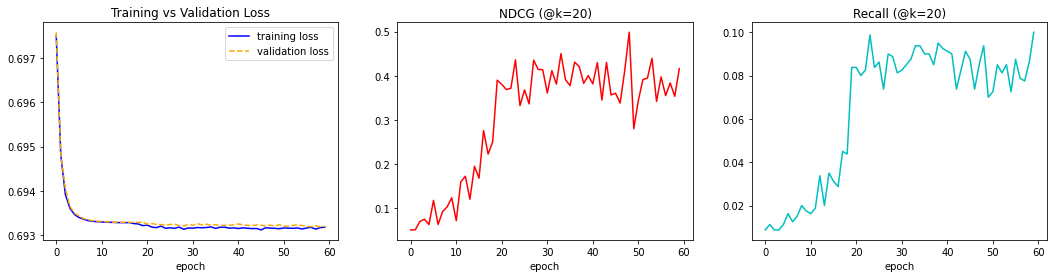

In [51]:
fig, axes = plt.subplots(1, 3, figsize=(18, 4))

axes[0].plot(model_history['loss'], color='b', label='training loss')
axes[0].plot(model_history['val_loss'], color='orange', linestyle='dashed', label='validation loss')
axes[0].set(title='Training vs Validation Loss', xlabel='epoch')
axes[0].legend()

axes[1].plot(model_history['val_ndcg'], color='r')
axes[1].set(title='NDCG (@k=20)', xlabel='epoch')

axes[2].plot(model_history['val_recall'], color='c')
axes[2].set(title='Recall (@k=20)', xlabel='epoch')

plt.show()

---
## Evaluation

In [52]:
model.evaluate(x_score)

17/17 [==============================] - 1s 78ms/step - loss: 0.6932 - ndcg: 0.4049 - recall: 0.1022


[0.6932477355003357, 0.4140898287296295, 0.11562500149011612]

In [53]:
pred_all = model.predict(x_score)
pred_all.shape

(1040, 20)

#### Predict One Example

The results returned by the model are absolute indices of the array made of movie IDs, which can be retrieved from the original dataframe column name array. Further, we can lookup for the movie titles respectively for user history (as model input), recommendations (model output) and masked history (ground truth), and check how much they overlap. 

In [54]:
def predict_one(uid, print_movies=False):

    global df_score_keep, df_score_mask, dict_movies, pred_all

    mask_idx = df_score_mask.iloc[uid]
    mask_mov = df_score_mask.columns[mask_idx].astype('int').tolist()
    pred_idx = pred_all[uid]
    pred_mov = sorted(df_score_keep.columns.astype('int').to_numpy()[pred_idx])
    good_mov = list(set(mask_mov).intersection(set(pred_mov)))

    if print_movies:
        print(f"Below movies reviewed by user {uid} were masked out:\n")
        for mov in mask_mov:
            print(str(mov).ljust(4), dict_movies[mov])
    
        print("-"*100 + "\nThese movies were recommened:\n")
        for mov in pred_mov:
            print(str(mov).ljust(4), dict_movies.get(mov, None))

        print("-"*100 + "\nOverlapping ones:\n")
        for mov in good_mov:
            print(str(mov).ljust(4), dict_movies.get(mov, None))        

    return len(good_mov)

_ = predict_one(53, print_movies=True)

Below movies reviewed by user 53 were masked out:

2    Jumanji (1995)
7    Sabrina (1995)
11   American President, The (1995)
110  Braveheart (1995)
141  Birdcage, The (1996)
203  To Wong Foo, Thanks for Everything! Julie Newmar (1995)
232  Eat Drink Man Woman (1994)
260  Star Wars: Episode IV - A New Hope (1977)
281  Nobody's Fool (1994)
292  Outbreak (1995)
314  Secret of Roan Inish, The (1994)
316  Stargate (1994)
318  Shawshank Redemption, The (1994)
368  Maverick (1994)
371  Paper, The (1994)
385  Man of No Importance, A (1994)
412  Age of Innocence, The (1993)
457  Fugitive, The (1993)
506  Orlando (1993)
532  Serial Mom (1994)
538  Six Degrees of Separation (1993)
590  Dances with Wolves (1990)
592  Batman (1989)
596  Pinocchio (1940)
597  Pretty Woman (1990)
780  Independence Day (ID4) (1996)
858  Godfather, The (1972)
898  Philadelphia Story, The (1940)
902  Breakfast at Tiffany's (1961)
904  Rear Window (1954)
916  Roman Holiday (1953)
921  My Favorite Year (1982)
924  2001:

In [55]:
results = []

for i in range(len(df_score)):
    n_overlap = predict_one(i)
    results.append(n_overlap)

In [56]:
best_id = np.argmax(results)
_ = predict_one(best_id, print_movies=True)

Below movies reviewed by user 635 were masked out:

6    Heat (1995)
10   GoldenEye (1995)
16   Casino (1995)
58   Postino, Il (The Postman) (1994)
110  Braveheart (1995)
111  Taxi Driver (1976)
150  Apollo 13 (1995)
161  Crimson Tide (1995)
172  Johnny Mnemonic (1995)
318  Shawshank Redemption, The (1994)
329  Star Trek: Generations (1994)
333  Tommy Boy (1995)
357  Four Weddings and a Funeral (1994)
381  When a Man Loves a Woman (1994)
383  Wyatt Earp (1994)
431  Carlito's Way (1993)
444  Even Cowgirls Get the Blues (1993)
475  In the Name of the Father (1993)
480  Jurassic Park (1993)
482  Killing Zoe (1994)
527  Schindler's List (1993)
532  Serial Mom (1994)
541  Blade Runner (1982)
573  Ciao, Professore! (Io speriamo che me la cavo ) (1993)
583  Dear Diary (Caro Diario) (1994)
597  Pretty Woman (1990)
608  Fargo (1996)
861  Supercop (1992)
910  Some Like It Hot (1959)
924  2001: A Space Odyssey (1968)
948  Giant (1956)
1097 E.T. the Extra-Terrestrial (1982)
1148 Wrong Trousers, Th

In [57]:
_ = predict_one(36, print_movies=True)

Below movies reviewed by user 36 were masked out:

1    Toy Story (1995)
25   Leaving Las Vegas (1995)
150  Apollo 13 (1995)
296  Pulp Fiction (1994)
457  Fugitive, The (1993)
509  Piano, The (1993)
597  Pretty Woman (1990)
916  Roman Holiday (1953)
1702 Flubber (1997)
1721 Titanic (1997)
2153 Avengers, The (1998)
2171 Next Stop, Wonderland (1998)
2355 Bug's Life, A (1998)
2628 Star Wars: Episode I - The Phantom Menace (1999)
2762 Sixth Sense, The (1999)
2943 Indochine (1992)
2987 Who Framed Roger Rabbit? (1988)
3101 Fatal Attraction (1987)
3125 End of the Affair, The (1999)
3163 Topsy-Turvy (1999)
3614 Honeymoon in Vegas (1992)
----------------------------------------------------------------------------------------------------
These movies were recommened:

110  Braveheart (1995)
111  Taxi Driver (1976)
590  Dances with Wolves (1990)
608  Fargo (1996)
858  Godfather, The (1972)
1198 Raiders of the Lost Ark (1981)
1200 Aliens (1986)
1214 Alien (1979)
1259 Stand by Me (1986)
1265 Ground

In [58]:
_ = predict_one(1000, print_movies=True)

Below movies reviewed by user 1000 were masked out:

6    Heat (1995)
16   Casino (1995)
47   Seven (Se7en) (1995)
111  Taxi Driver (1976)
123  Chungking Express (1994)
426  Body Snatchers (1993)
492  Manhattan Murder Mystery (1993)
608  Fargo (1996)
919  Wizard of Oz, The (1939)
999  2 Days in the Valley (1996)
1086 Dial M for Murder (1954)
1210 Star Wars: Episode VI - Return of the Jedi (1983)
1214 Alien (1979)
1240 Terminator, The (1984)
1252 Chinatown (1974)
1343 Cape Fear (1991)
1358 Sling Blade (1996)
1499 Anaconda (1997)
1519 Broken English (1996)
1544 Lost World: Jurassic Park, The (1997)
1653 Gattaca (1997)
1711 Midnight in the Garden of Good and Evil (1997)
1760 Spice World (1997)
1913 Picnic at Hanging Rock (1975)
1950 In the Heat of the Night (1967)
2162 NeverEnding Story II: The Next Chapter, The (1990)
2181 Marnie (1964)
2284 Bandit Queen (1994)
2349 Mona Lisa (1986)
2405 Jewel of the Nile, The (1985)
2551 Dead Ringers (1988)
2791 Airplane! (1980)
2802 Tequila Sunrise (19